# Import

In [1]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
from torch.utils.tensorboard import SummaryWriter

In [138]:
%matplotlib inline
from tqdm import trange
from pytorch_metric_learning import losses, miners, samplers, trainers, testers
from pytorch_metric_learning.utils import common_functions
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.utils.inference import MatchFinder, InferenceModel
from pytorch_metric_learning.utils import loss_and_miner_utils as lmu
import pytorch_metric_learning.utils.logging_presets as logging_presets
import numpy as np
import torchvision
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import logging
import matplotlib.pyplot as plt
import umap
from cycler import cycler
import record_keeper
import pytorch_metric_learning
import os
from torchvision.datasets.folder import default_loader
import datetime

import itertools
from scipy.spatial.distance import pdist, cdist
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

logging.getLogger().setLevel(logging.INFO)

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

In [7]:
from src import params
from src.dataset import (get_transforms, get_cub_2011, get_cub_2011_class_disjoint, get_inverse_transform)
from src.models import (get_embedder, get_trunk)
from src.training import (get_optimizers, get_loss, get_miner, get_sampler, get_testing_hooks)
from src.utils import get_experiment_id, git_version
from src.evaluation import get_inference_model, get_scores, get_embeddings

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
print("Git commit hash", git_version())

Git commit hash 0f749570afdca29ebd90469453cdfb3fee39d702


In [10]:
import sys
sys.path.append('/home/btseytlin/metric_benchmarks/runners')

In [11]:
from hotels50k import Hotels50kDataset

# Prepare dataset and model base classes

In [12]:
train_transform, val_transform = get_transforms()

In [92]:
dataset = Hotels50kDataset(root='/home/btseytlin/metric_benchmarks/hotels50k', target='chains', download=False, transform=val_transform)

Loading image folders
Concatting dataset
Getting labels
Done loading dataset


# Load model

In [150]:
experiment_root = '/home/btseytlin/metric_benchmarks/experiments/hotels_contrastive_triplet/hotels_contrastive_triplet2_reproduction4/UsingOriginalTest_Partitions4_0/saved_models/'
embedder_path, trunk_path = (f'{experiment_root}/embedder_best8.pth',
 f'{experiment_root}/trunk_best8.pth')

In [151]:
import pretrainedmodels # needs to be installed with pip
from pytorch_metric_learning.utils import common_functions as c_f
from powerful_benchmarker import architectures
import torch

trunk = pretrainedmodels.bninception()
trunk.last_linear = c_f.Identity()
embedder = architectures.misc_models.MLP([1024, 128])

trunk.load_state_dict(torch.load(trunk_path))
embedder.load_state_dict(torch.load(embedder_path))

<All keys matched successfully>

In [152]:
trunk = trunk.to(device)
embedder = embedder.to(device)

In [153]:
inference_model = get_inference_model(trunk, embedder)

In [154]:
gallery_dataset = dataset.original_train_dataset
query_dataset = dataset.original_test_dataset

In [155]:
gallery_labels = dataset.labels[dataset.train_indices]
query_labels = dataset.labels[dataset.test_indices]

len(gallery_labels), len(query_labels)

(85069, 10899)

In [156]:
def get_model_device(model):
    return next(model.parameters()).device

def get_many_embeddings(dataset, inference_model, batch_size=100, emb_dim=128):
    embeddings = torch.zeros(len(dataset), emb_dim)
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=6)
    chains = []
    hotels = []
    for i, batch in tqdm(enumerate(loader), total=len(loader)):
        tensors = batch[0]
        chain, hotel = batch[1][0], batch[1][1]
        chains += list(chain)
        hotels += list(hotels)
        embeddings[i*batch_size:i*batch_size+batch_size] = inference_model.get_embeddings(tensors.to(device), None)[0]
        
    assert not embeddings.isnan().any().item()
    return embeddings


In [157]:
gallery_embeddings = get_many_embeddings(gallery_dataset, inference_model)
query_embeddings = get_many_embeddings(query_dataset, inference_model)

In [158]:
pd.Series(gallery_labels).value_counts()

-1     33485
 92     5761
 91     3708
 2      3091
 3      2647
       ...  
 20       29
 12       26
 7        26
 10       21
 11       13
Length: 90, dtype: int64

In [159]:
gallery_embeddings[:10], gallery_embeddings[-10:]

(tensor([[ 0.0351,  0.0606,  0.0272,  ..., -0.1304,  0.0560, -0.0725],
         [ 0.0535,  0.0719,  0.0789,  ..., -0.1400,  0.0132, -0.0776],
         [ 0.0634,  0.0094,  0.1189,  ..., -0.1557,  0.0245, -0.0702],
         ...,
         [ 0.0724,  0.0917,  0.0713,  ..., -0.1358,  0.0159, -0.0704],
         [ 0.0720,  0.0689,  0.0416,  ..., -0.1838,  0.0356, -0.0881],
         [ 0.0636,  0.0408,  0.0563,  ..., -0.1462,  0.0596, -0.0704]]),
 tensor([[ 0.0838,  0.0443,  0.0554,  ..., -0.1960,  0.0557, -0.0630],
         [ 0.0931,  0.0466,  0.0184,  ..., -0.1601,  0.0420, -0.0718],
         [ 0.0694,  0.0838,  0.0394,  ..., -0.1666,  0.0511, -0.0874],
         ...,
         [ 0.0714,  0.0172,  0.0654,  ..., -0.1599,  0.0570, -0.0985],
         [ 0.0676,  0.0321,  0.1064,  ..., -0.1895,  0.0343, -0.1050],
         [ 0.0428,  0.0582,  0.0983,  ..., -0.1307,  0.0337, -0.0673]]))

In [160]:
assert len(gallery_embeddings) == len(gallery_labels)
assert len(query_embeddings) == len(query_labels)

In [161]:
inference_model.indexer.train_index(gallery_embeddings.cpu().numpy())

## Visual evaluation

In [162]:
inv_normalize = get_inverse_transform()

def print_decision(is_match):
    if is_match:
        print("Same class")
    else:
        print("Different class")

def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize = figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [163]:
class_a = query_labels[0]
class_b = query_labels[100]

class_a_idx = (query_labels == class_a).nonzero()[0]
class_b_idx = (query_labels == class_b).nonzero()[0]

In [164]:
class_a, class_b

(38, 64)

In [165]:
class_a_idx[:10], class_b_idx[:10]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26]))

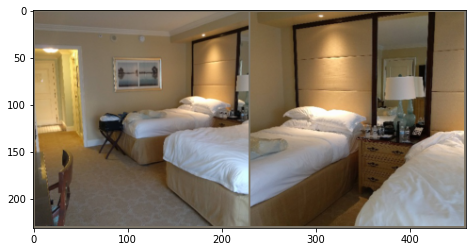

Same class


In [166]:
# compare two images of the same class
(x, _), (y, _) = query_dataset[class_a_idx[0]], query_dataset[class_a_idx[1]]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0).to(device), y.unsqueeze(0).to(device))
print_decision(decision)

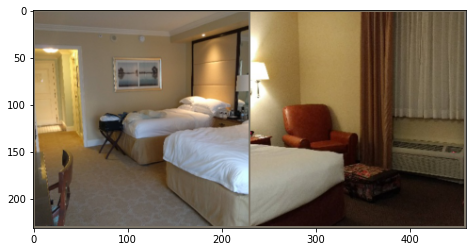

Same class


In [167]:
# compare two images of different classes
(x, _), (y, _) = query_dataset[class_a_idx[0]], query_dataset[class_b_idx[1]]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0).to(device), y.unsqueeze(0).to(device))
print_decision(decision)

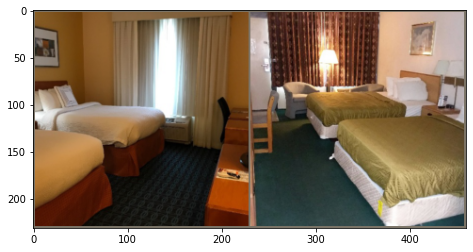

Same class
89 70
Actually different


In [168]:
# compare two random images
idx1 = np.random.choice(range(len(query_dataset)))
idx2 = np.random.choice(range(len(query_dataset)))
(x, x_label), (y, y_label) = query_dataset[idx1], query_dataset[idx2]
x_label = x_label[0]
y_label = y_label[0]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0).to(device), y.unsqueeze(0).to(device))
print_decision(decision)
print(x_label, y_label)
print('Actually same' if x_label==y_label else "Actually different")

## Retrieval

In [169]:
trunk = trunk.to('cpu')

In [170]:
embedder = embedder.to('cpu')

distances [[0.01844762 0.0210374  0.02125118 0.02231264 0.02301139]]


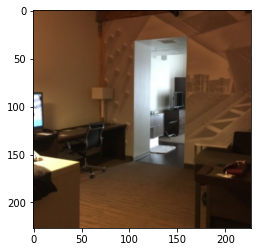

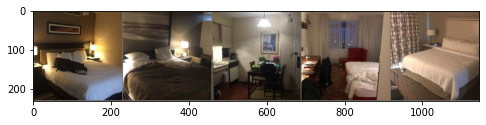

Query label 41
Neighbor labels [ 1 83 77 -1 74]


In [171]:
k = 5
query_idx = np.random.randint(0, len(query_dataset))
#query_idx = 4226 # hardest class
#query_idx = 4080 # class 136, very hard
#query_idx = 2070 # easiest class
query_img = query_dataset[query_idx][0]
query_batch =  [query_img]
# D, I = index.search(query_batch, k)
# print(D)

I, D = inference_model.get_nearest_neighbors(query_batch, k=k)
print('distances', D)
neighbors_idx = I[0]
neighbors_imgs = [gallery_dataset[i][0] for i in neighbors_idx]
neighbors_labels = gallery_labels[neighbors_idx]

imshow(query_img)

imshow(torchvision.utils.make_grid(torch.stack(neighbors_imgs, dim=0)))
print('Query label', gallery_labels[query_idx])
print('Neighbor labels', neighbors_labels)

# Pairwise distances

In [172]:
def get_pairwise_distances(embeddings, labels, sample_size=1000):
    same_label_distances = {}
    diff_label_distances = {}

    def get_label_vectors(label):
        label_indices = np.array(range(len(labels)))[labels == label]
        vectors = [embeddings[i].numpy() for i in label_indices]    
        return vectors

    for label in tqdm(set(labels)):
        vectors = get_label_vectors(label)
        
        vectors = vectors[:sample_size]

        distances = pdist(vectors, metric='cosine')
        same_label_distances[label] = distances

        diff_labels = list(set(labels).difference(set([label])))
        other_label = np.random.choice(diff_labels)
        other_vectors = get_label_vectors(other_label)
        
        other_vectors = other_vectors[:sample_size]

        other_distances_matrix = cdist(vectors, other_vectors)
        other_distances = []
        # Get upper triangle of matrix
        for i in range(len(other_distances_matrix)-1):
            other_distances.append(other_distances_matrix[i][i+1:])
        other_distances = np.concatenate(other_distances)

        diff_label_distances[(label, other_label)] = other_distances
        
    random_indices = np.random.choice(range(len(labels)), sample_size)
    
    print('computing random dists')
    random_distances = pdist(embeddings[random_indices].numpy(), metric='cosine')
    print('Concatting stuff')
    all_same_label_dists = np.concatenate([dists for l, dists in same_label_distances.items()])
    all_diff_label_distances = np.concatenate([dists for l, dists in diff_label_distances.items()])
    
    return random_distances, all_same_label_dists, all_diff_label_distances, same_label_distances, diff_label_distances



computing random dists
Concatting stuff


/home/btseytlin/metric_benchmarks/venv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/btseytlin/metric_benchmarks/venv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/btseytlin/metric_benchmarks/venv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fi

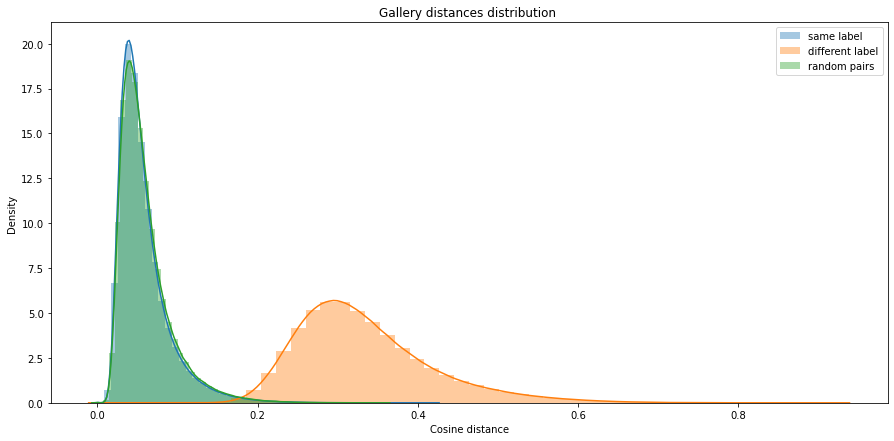

In [173]:
random_distances, all_same_label_dists, all_diff_label_distances, same_label_distances, diff_label_distances = get_pairwise_distances(gallery_embeddings, gallery_labels)
plt.figure(figsize=(15, 7))
sns.distplot(all_same_label_dists, label='same label')
sns.distplot(all_diff_label_distances, label='different label')
sns.distplot(random_distances, label='random pairs')
plt.xlabel('Cosine distance')
plt.title("Gallery distances distribution ")
plt.legend()
plt.show()


computing random dists
Concatting stuff


/home/btseytlin/metric_benchmarks/venv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/btseytlin/metric_benchmarks/venv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/btseytlin/metric_benchmarks/venv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fi

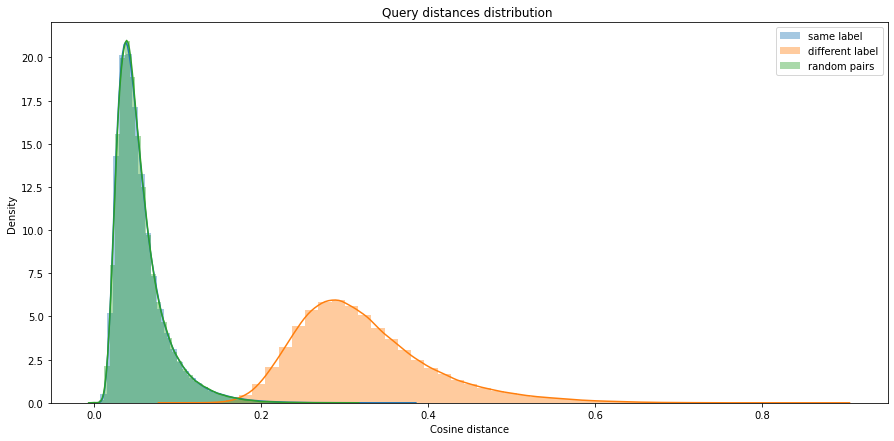

In [174]:
random_distances, all_same_label_dists, all_diff_label_distances, same_label_distances, diff_label_distances = get_pairwise_distances(query_embeddings, query_labels)
plt.figure(figsize=(15, 7))
sns.distplot(all_same_label_dists, label='same label')
sns.distplot(all_diff_label_distances, label='different label')
sns.distplot(random_distances, label='random pairs')
plt.xlabel('Cosine distance')
plt.title("Query distances distribution ")
plt.legend()
plt.show()

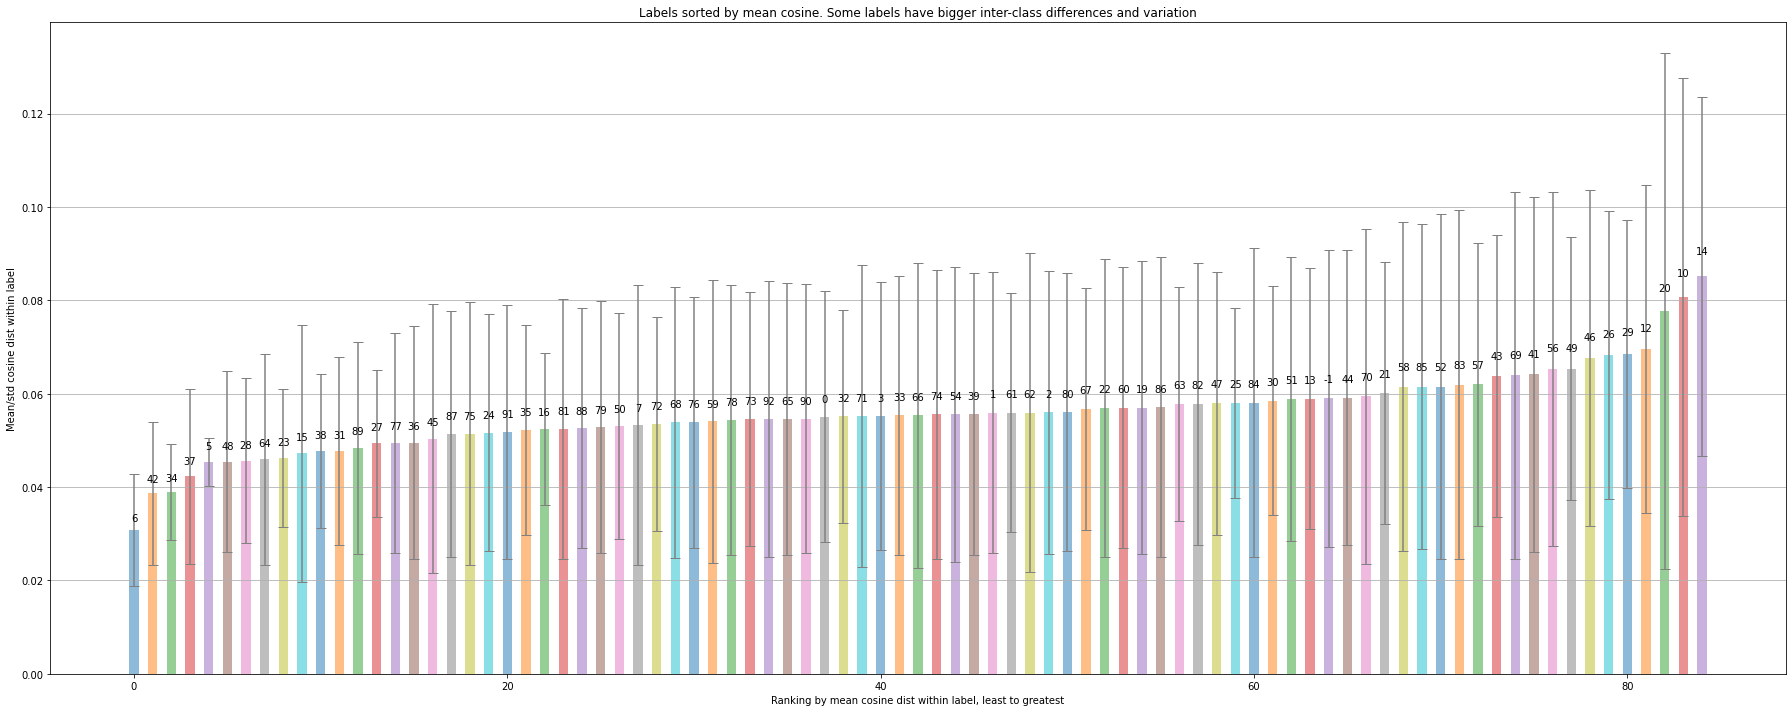

In [175]:
means = []
stds = []
for label, distances in same_label_distances.items():
    means.append(np.mean(distances))
    stds.append(np.std(distances))
    
sort_order = np.argsort(means)

labels = [label for label in same_label_distances]
sorted_labels = np.array(labels)[sort_order]

def autolabel(rects, text):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                text,
                ha='center', va='bottom')
        
fig, ax = plt.subplots(figsize=(25, 10))
width = 0.5
for i, label in enumerate(sorted_labels):
    distances = same_label_distances[label]
    rects = ax.bar(i, np.mean(distances), width, yerr=np.std(distances), align='center', alpha=0.5, ecolor='grey', capsize=5)
    autolabel(rects, f'{label}')
    
    ax.yaxis.grid(True)


plt.ylabel("Mean/std cosine dist within label")
plt.xlabel('Ranking by mean cosine dist within label, least to greatest')
# Save the figure and show
plt.title("Labels sorted by mean cosine. Some labels have bigger inter-class differences and variation")
plt.tight_layout()
plt.show()

Large inter-class distances == worse predictions

# Umap

In [176]:
plotting_transform = transforms.Compose([
    get_inverse_transform(),
    transforms.ToPILImage(),
    transforms.Resize(30),
])


def plot_umap(dataset, embeddings, labels):
    reducer = umap.UMAP()
    reduced = reducer.fit_transform(embeddings)
    
    str_labels = np.array(list(map(lambda x: 'l'+x, labels.astype(str))))
    
    reduced_x = reduced[:, 0]
    reduced_y = reduced[:, 1]
    
    #plt.scatter(x=reduced_x[:1], y=reduced_y[:1])
    
    _, uniq_label_idx = np.unique(labels, return_index=True)
    for ix, i in enumerate(uniq_label_idx):
        img, label = dataset[i][0], labels[i] 
        img = plotting_transform(img)
        npimg = np.array(img)
        
        if ix+1 < len(uniq_label_idx):
            x, y = reduced_x[i:uniq_label_idx[ix+1]].mean(), reduced_y[i:uniq_label_idx[ix+1]].mean()
        else:
            x, y = reduced_x[i:].mean(), reduced_y[i:].mean()
        
        
        ab = AnnotationBbox(OffsetImage(npimg), (x, y), frameon=False)
        ax = plt.gca()
        ax.add_artist(ab)
        
    sns.scatterplot(x=reduced_x, y=reduced_y, hue=str_labels, legend=False, alpha=0.3)
    
    

<ipython-input-176-1181b5d1cfd5>:26: RuntimeWarning: Mean of empty slice.
  x, y = reduced_x[i:uniq_label_idx[ix+1]].mean(), reduced_y[i:uniq_label_idx[ix+1]].mean()
/home/btseytlin/metric_benchmarks/venv/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


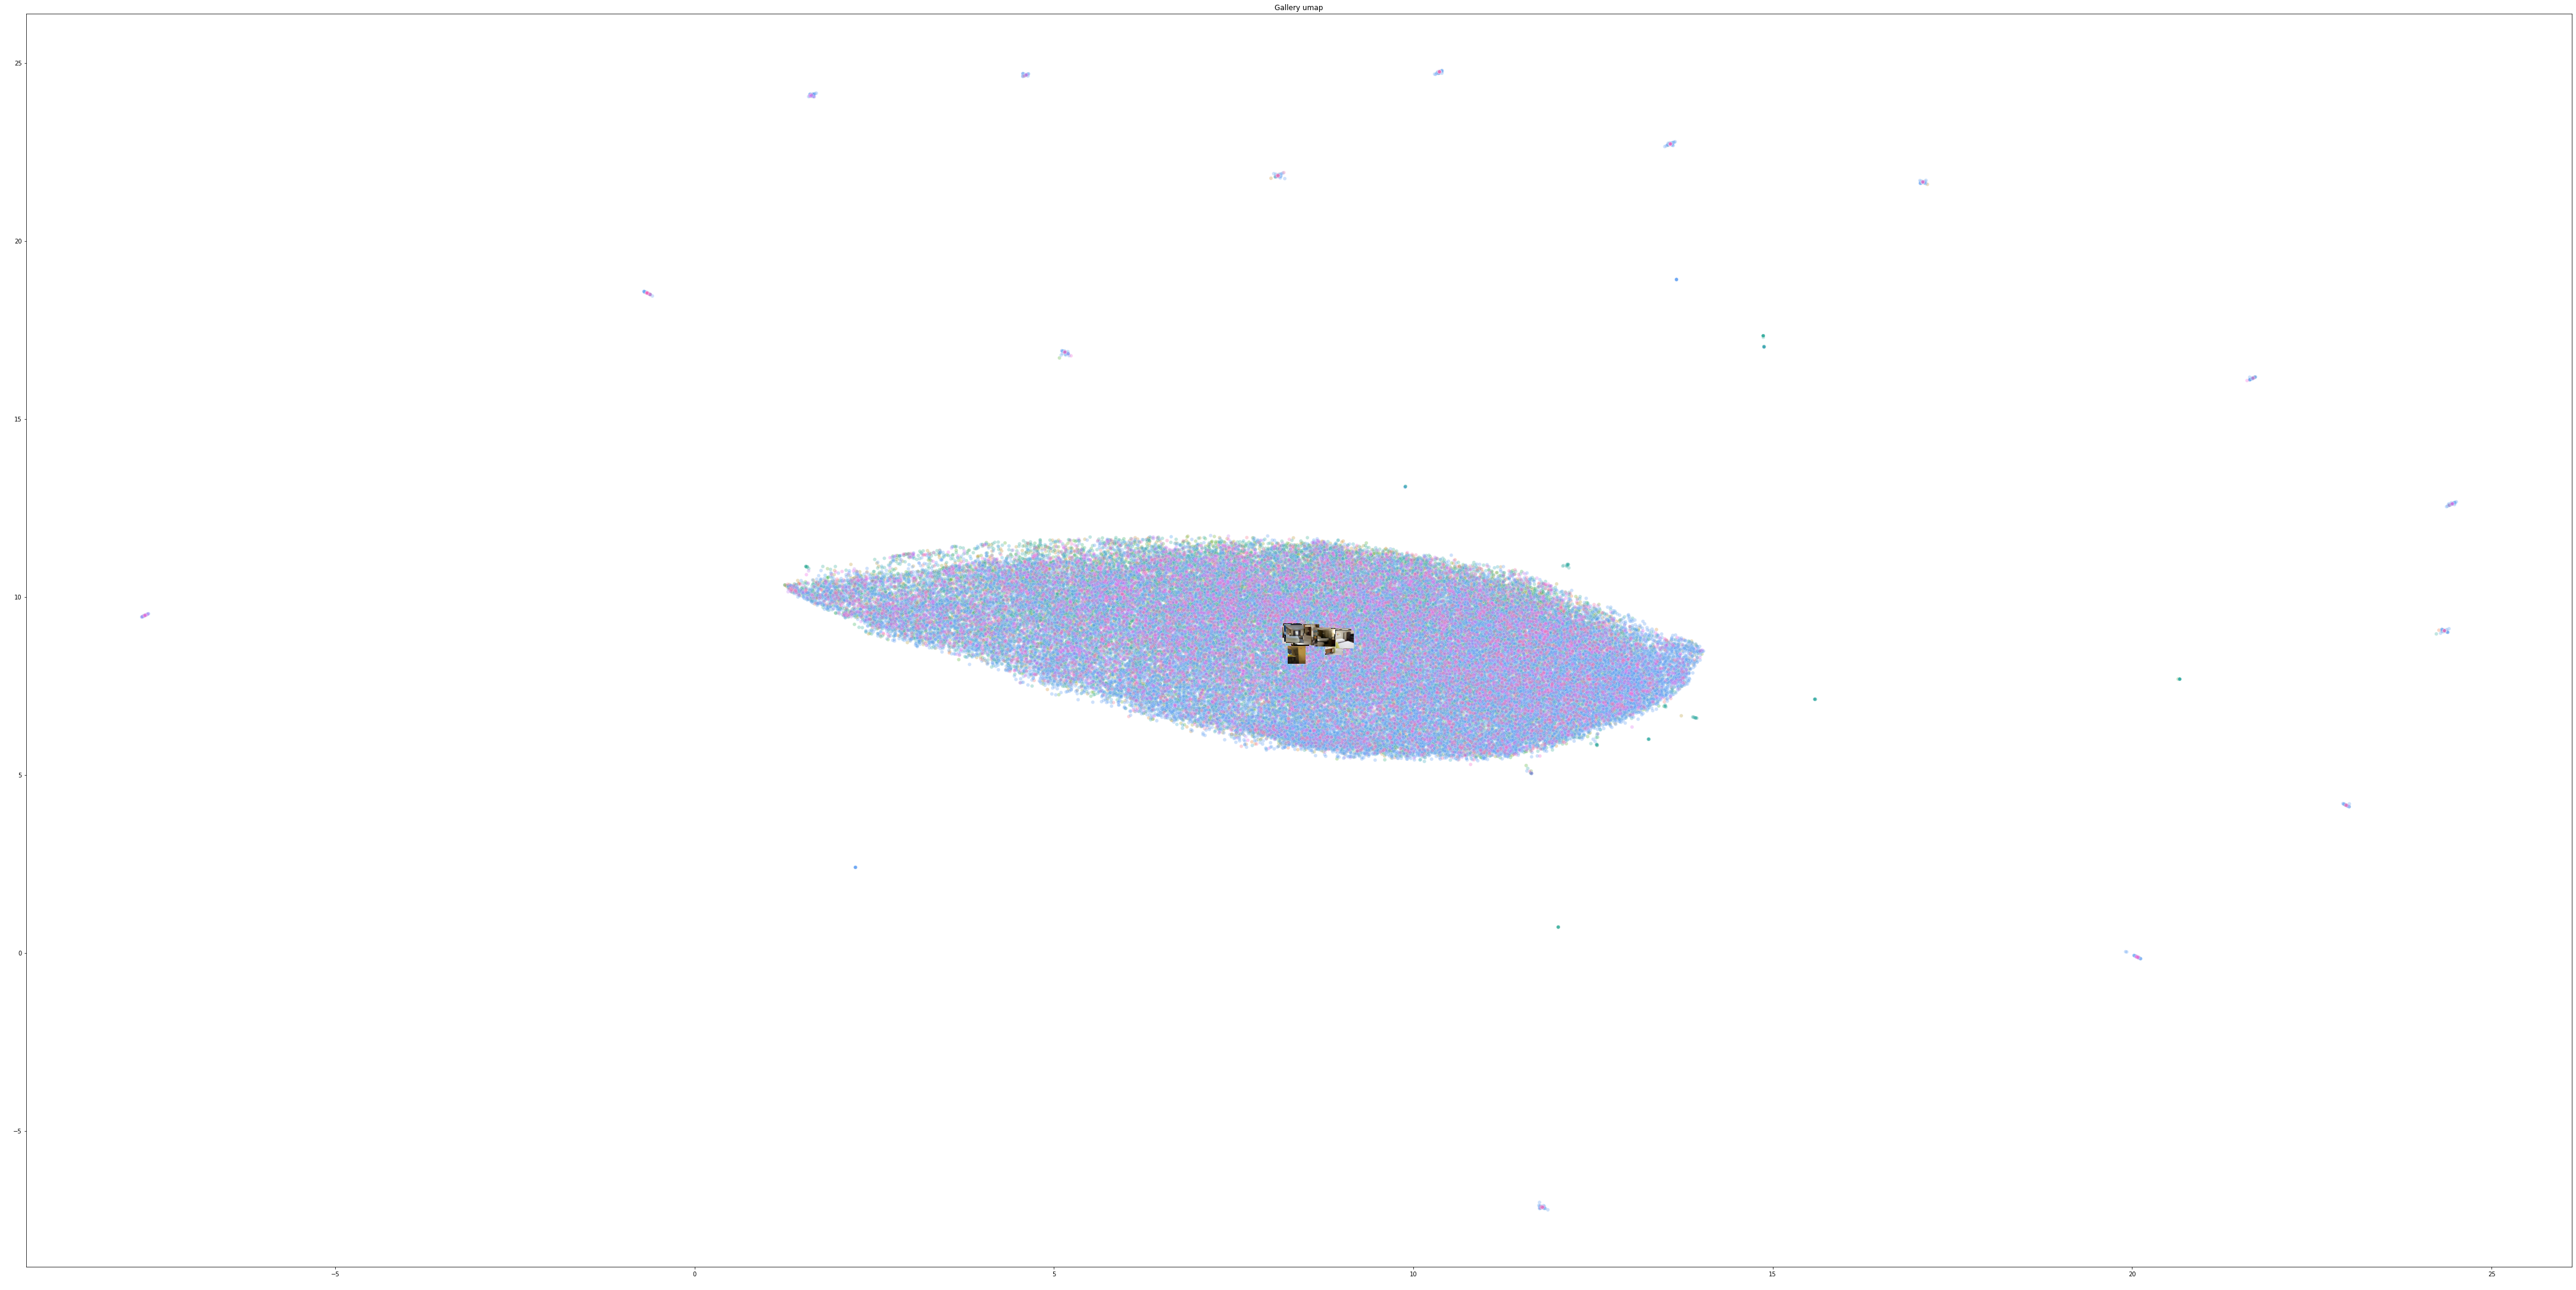

In [177]:
plt.figure(figsize=(60, 30))    
plot_umap(gallery_dataset, gallery_embeddings, gallery_labels)
plt.title("Gallery umap")
plt.tight_layout()
plt.show()

<ipython-input-176-1181b5d1cfd5>:26: RuntimeWarning: Mean of empty slice.
  x, y = reduced_x[i:uniq_label_idx[ix+1]].mean(), reduced_y[i:uniq_label_idx[ix+1]].mean()
/home/btseytlin/metric_benchmarks/venv/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


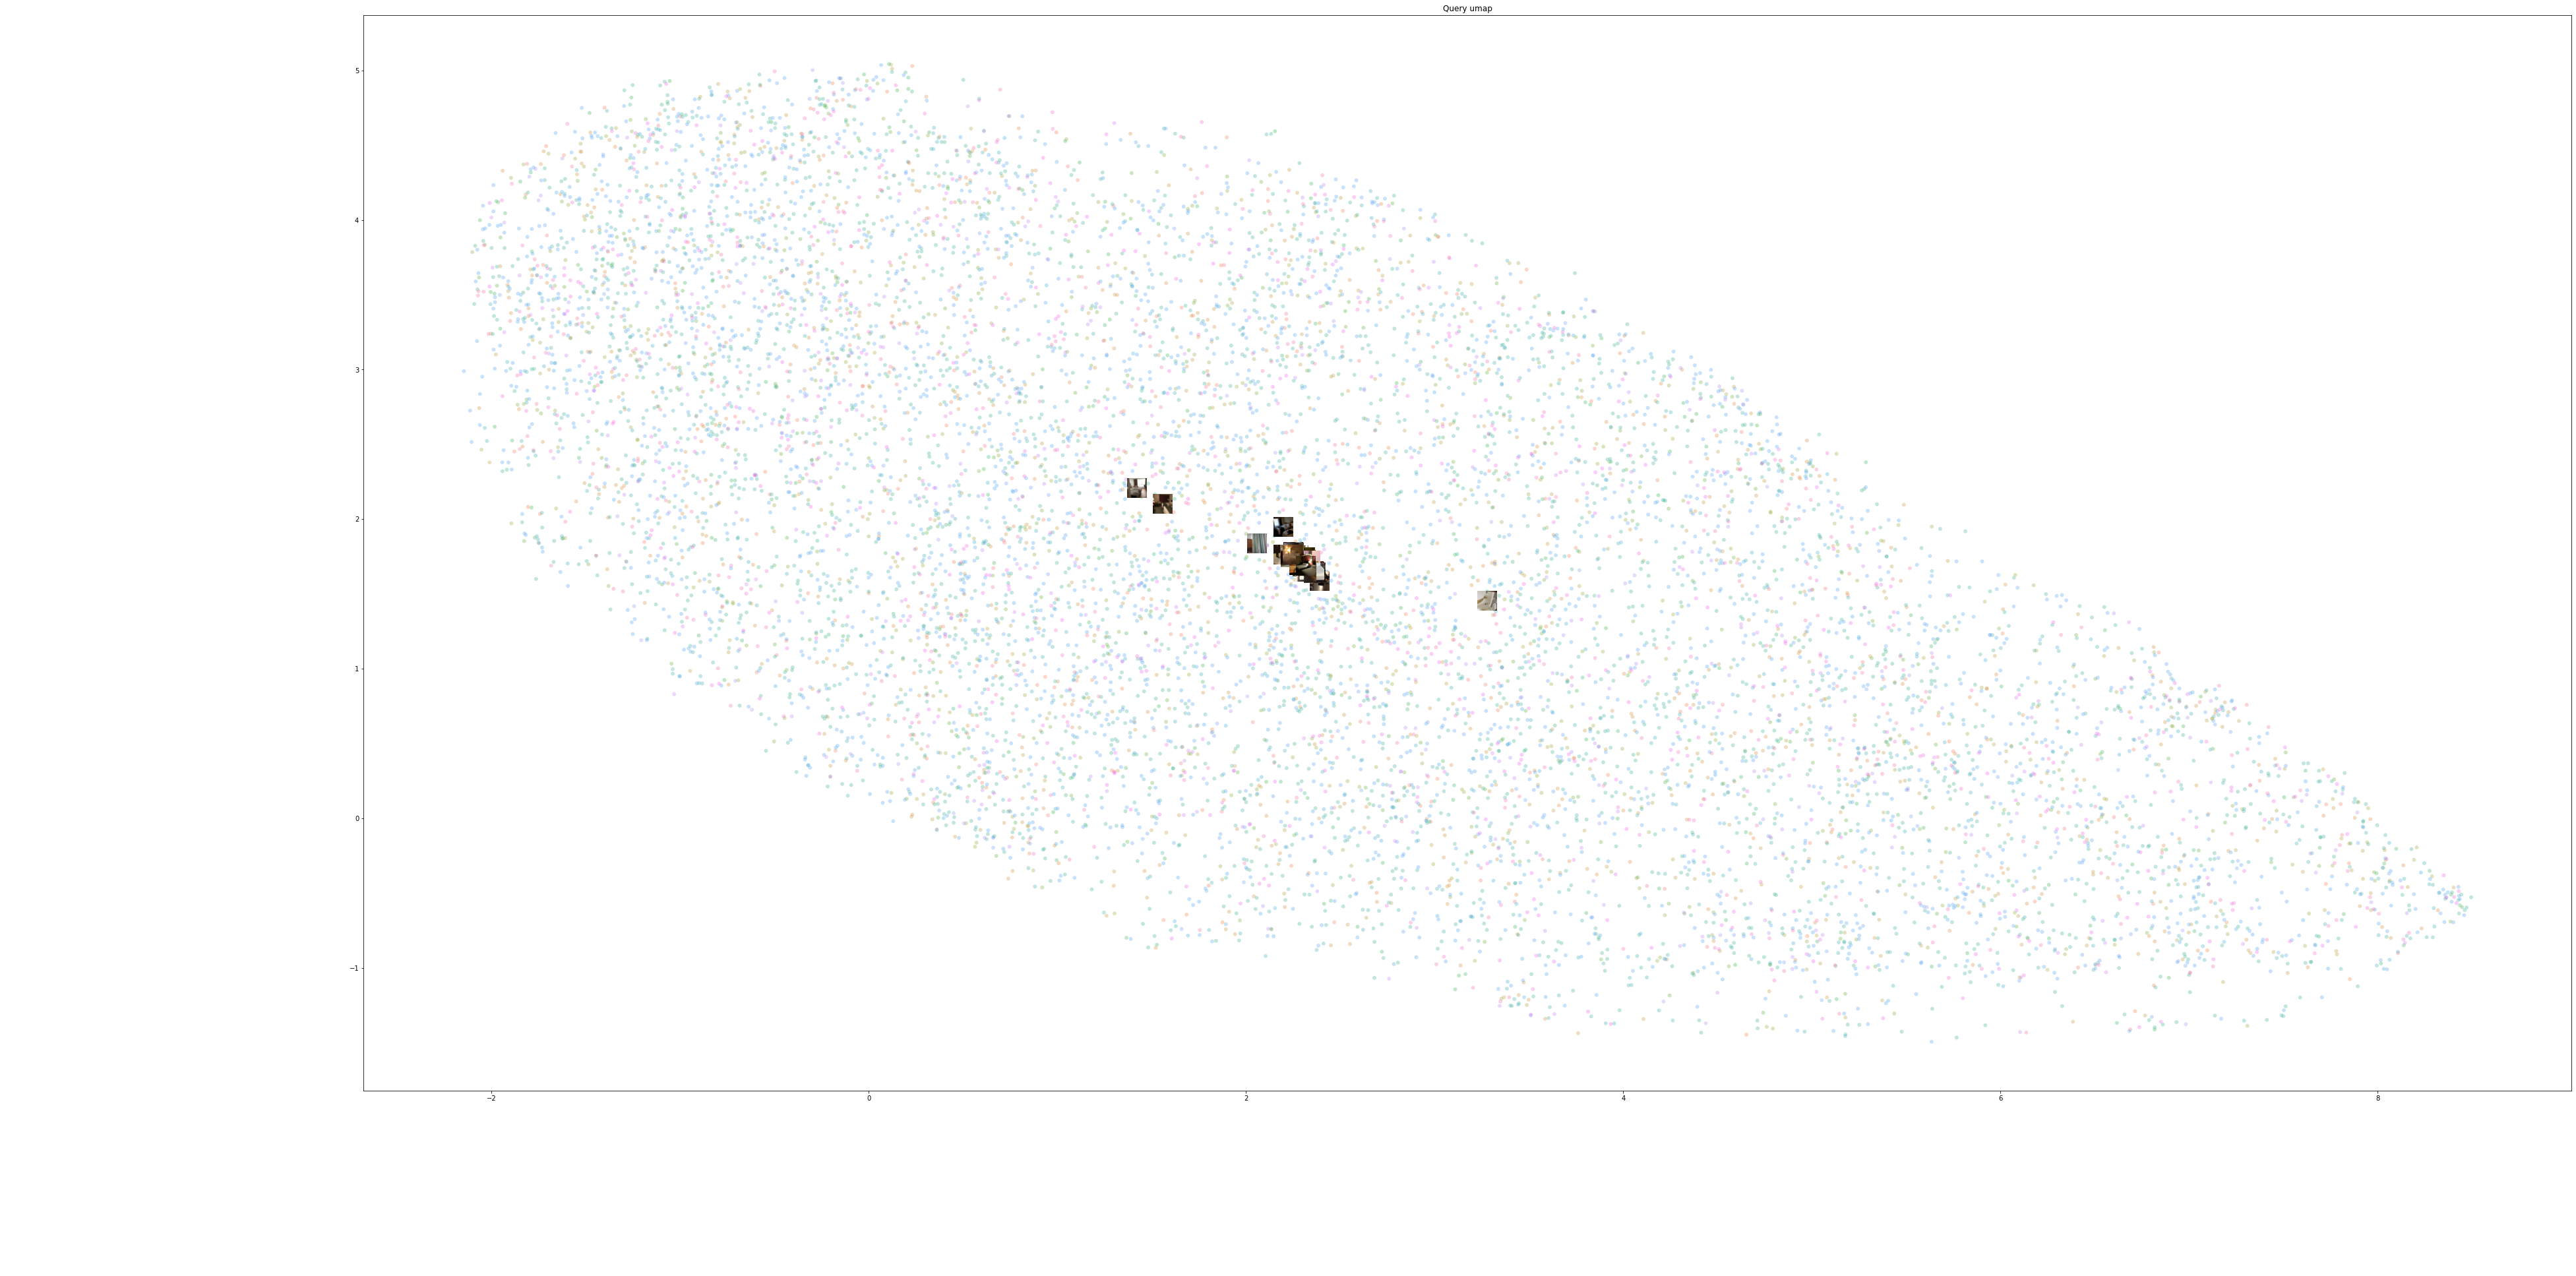

In [178]:
plt.figure(figsize=(60, 30))    
plot_umap(query_dataset, query_embeddings, query_labels)
plt.title("Query umap")
plt.show()